# Notebook: Dataset creation

Each run-to-failure cycle it's represented as a data frame. Cycles belonging to the same dataset may not have the same number of features

Let's start by creating a function for returning a random data frame. Each dataframe will have a random duration and a random number of features. The first feature will be categorical, the remanining ones numeric.

## Mock data 

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn
seaborn.set()

def random_life():
    Nr = np.random.randint(50, 2000)
    Nc = np.random.randint(5, 15)
    
    df = pd.DataFrame(
        np.random.randn(Nr, Nc),
        columns=[f'Feature_{i+1}' for i in range(Nc)]
    )
    df[f'Feature_{0}'] = np.random.choice(a=['Yes', 'No'], size=(Nr,))
    df['RUL'] = np.linspace(Nr, 0, Nr)
    return df

## Dataset creation


In order to define a dataset you should subclass `AbstractTimeSeriesDataset` and define three methods:

* `__getitem__(self, i) -> pd.DataFrame`: This method should return the i-th life
* `n_time_series(self) -> int`: The property return the total number of lives present in the dataset
* `rul_column(self) -> str`: The property should return the name of the RUL column

In [17]:

from ceruleo.dataset.ts_dataset import AbstractLivesDataset


class CustomDataset(AbstractLivesDataset):
    def __init__(self):
        super().__init__()
        self.lives = []
        for i in range(50):
            self.lives.append( random_life())

    def get_time_series(self, i):
        return self.lives[i]

    @property
    def rul_column(self) -> str:
        return "RUL"
        
    @property
    def n_time_series(self):
        return len(self.lives)

## Dataset instantiation

In [18]:
dataset = CustomDataset()

### Dataset features

Since the run-to-failure cycles have differnet feature space. We can obtain the subset that is common to all of the cycles.

In [19]:
dataset.common_features()

['Feature_0',
 'Feature_1',
 'Feature_2',
 'Feature_3',
 'Feature_4',
 'Feature_5',
 'RUL']

In [20]:
dataset.numeric_features()

['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'RUL']

In [21]:
dataset.categorical_features()

['Feature_0']

### Number of run-to-cycle failures

In [22]:
len(dataset)

50

### Dataset iteration

Datasets are iterable. Each element of the iteration is the pandas DataFrame that stores the run-to-failure cycle

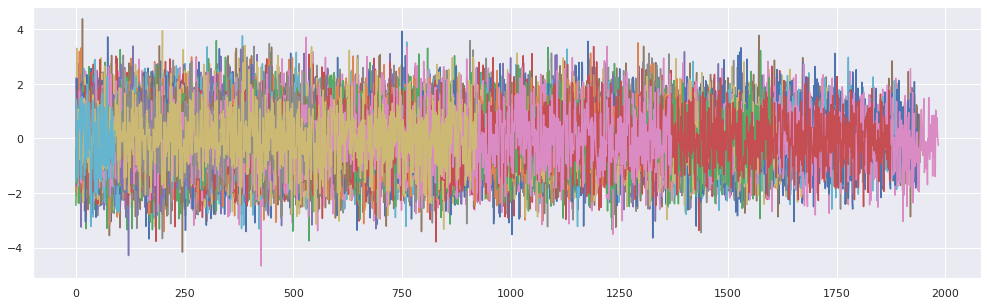

In [27]:
fig, ax = plt.subplots(figsize=(17, 5))
feature = dataset.numeric_features()[0]
for life in dataset:
    ax.plot(life[feature])

    

### Run-to-failure cycles duration

(array([ 3.,  4., 12.,  1.,  6.,  2.,  5.,  4.,  5.,  8.]),
 array([  90. ,  279.5,  469. ,  658.5,  848. , 1037.5, 1227. , 1416.5,
        1606. , 1795.5, 1985. ]),
 <BarContainer object of 10 artists>)

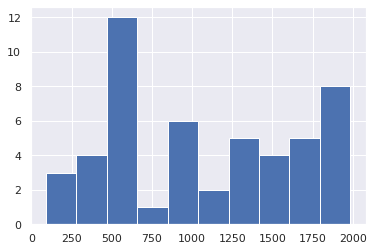

In [23]:
fig, ax = plt.subplots()
ax.hist(dataset.durations())

### Train-test split based on the cycles

When training machine learning model, it's essential to have evaluation sets well defined. In the context of predictive maintenance, the split should be made at the level of cycles. The dataset instance is compatible with all the `sklearn.model_selection` functions for splitting data.

In [24]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(dataset, train_size=0.8)

In [25]:
pd.DataFrame({
    'Cycles in the whole dataset': [len(dataset)],
    'Cycles in the training dataset': [len(train_dataset)],
    'Cycles in the test dataset': [len(test_dataset)],
}).T


,0
Cycles in the whole dataset,50
Cycles in the training dataset,40
Cycles in the test dataset,10


(array([1., 3., 1., 1., 0., 1., 0., 1., 1., 1.]),
 array([ 274. ,  416.7,  559.4,  702.1,  844.8,  987.5, 1130.2, 1272.9,
        1415.6, 1558.3, 1701. ]),
 <BarContainer object of 10 artists>)

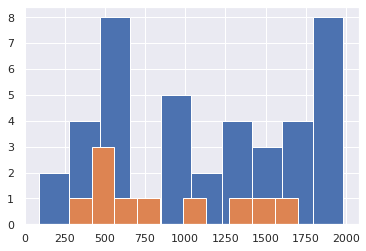

In [26]:
fig, ax = plt.subplots()
ax.hist(train_dataset.durations())
ax.hist(test_dataset.durations())